<a href="https://colab.research.google.com/github/Lilyexe/BME3053C-Final-Project/blob/main/BME3053c_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
!pip install --upgrade --force-reinstall numpy
!pip install --upgrade --force-reinstall torch torchvision torchaudio


# Mounts Google Drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
langchain 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.
pytensor 2.26.3 requires numpy<2,>=1.17.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U --force-reinstall numpy==1.26.4
!pip install -U torch torchvision
!pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


In [ ]:
import os
import shutil
from skimage.io import imread, imsave
from skimage.util import img_as_ubyte
import numpy as np


# Input directories
zip_extracted_dir = "/content/drive/MyDrive/BME3053c_Final/data/stage1_train"
image_output_dir = "/content/drive/MyDrive/BME3053c_Final/data/stage1_train_images"
mask_output_dir = "/content/drive/MyDrive/BME3053c_Final/data/stage1_train_masks"

# Create output directories
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(mask_output_dir, exist_ok=True)

# Process each sample folder
for folder_name in os.listdir(zip_extracted_dir):
    sample_folder = os.path.join(zip_extracted_dir, folder_name)
    if os.path.isdir(sample_folder):
        # Load the single image
        image_folder = os.path.join(sample_folder, "images")
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        image = imread(image_path)

        # Save the image to the output directory
        image_save_path = os.path.join(image_output_dir, f"{folder_name}.png")
        imsave(image_save_path, img_as_ubyte(image))  # Save as uint8 format

        # Combine all masks into one
        mask_folder = os.path.join(sample_folder, "masks")
        combined_mask = None
        for mask_file in os.listdir(mask_folder):
          mask_path = os.path.join(mask_folder, mask_file)
          mask = imread(mask_path, as_gray=True).astype(bool)  # Read as Boolean
          if combined_mask is None:
            combined_mask = mask
          else:
            combined_mask = np.logical_or(combined_mask, mask)

        combined_mask = combined_mask.astype(np.uint8) * 255  # Convert to uint8

        # Save the combined mask
        mask_save_path = os.path.join(mask_output_dir, f"{folder_name}_mask.png")
        imsave(mask_save_path, img_as_ubyte(combined_mask))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-26-c8be45a11c9d>:31: UserWarning: /content/drive/MyDrive/BME3053c_Final/data/stage1_train_images/07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770.png is a low contrast image
  imsave(image_save_path, img_as_ubyte(image))  # Save as uint8 format
<ipython-input-26-c8be45a11c9d>:48: UserWarning: /content/drive/MyDrive/BME3053c_Final/data/stage1_train_masks/07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770_mask.png is a low contrast image
  imsave(mask_save_path, img_as_ubyte(combined_mask))
<ipython-input-26-c8be45a11c9d>:31: UserWarning: /content/drive/MyDrive/BME3053c_Final/data/stage1_train_images/220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a.png is a low contrast image
  imsave(image_save_path, img_as_ubyte(image))  # Save as uint8 format
<ipython-input-26-c8be45a11c9d>:48: UserWarning: /content/drive/MyDrive/BME3053c_Final/data/stage1_train_masks/220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a_mask.png 

IndexError: list index out of range

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
from skimage.transform import resize
import numpy as np

class CellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.png', '_mask.png'))
        image = imread(img_path)
        mask = imread(mask_path, as_gray=True)

        # Convert image to RGB if it has an alpha channel
        if image.shape[2] == 4:  # Check if image has 4 channels
            image = image[:, :, :3]  # Select only the first 3 channels (RGB)

        # Resize
        image = resize(image, self.img_size, preserve_range=True)
        mask = resize(mask, self.img_size, preserve_range=True)

        # Normalize
        image = image / 255.0
        mask = (mask > 0).astype(np.float32)  # Binary mask

        # Convert to PyTorch tensors
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)  # CxHxW
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # 1xHxW
        return image, mask

# Paths to your data
image_dir = "/content/drive/MyDrive/BME3053c_Final/data/stage1_train_images"
mask_dir = "/content/drive/MyDrive/BME3053c_Final/data/stage1_train_masks"
dataset = CellDataset(image_dir, mask_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        e3 = self.enc3(p2)
        p3 = self.pool(e3)
        e4 = self.enc4(p3)
        p4 = self.pool(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        # Final output
        return torch.sigmoid(self.final(d1))

model = UNet()


In [ ]:
import torch.optim as optim

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


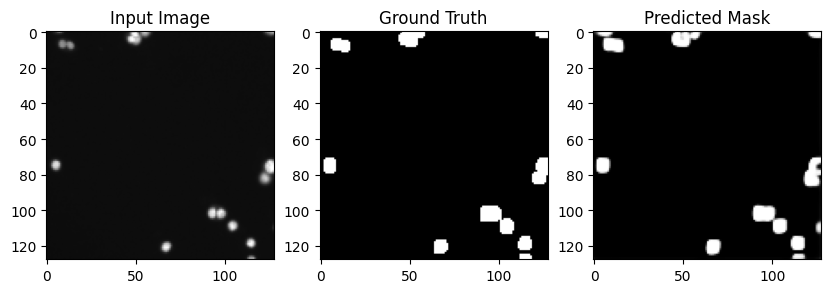

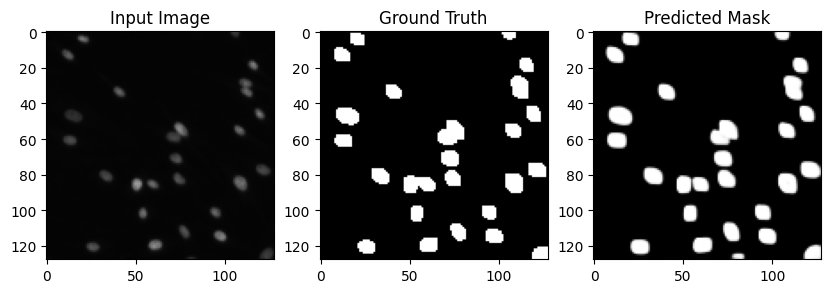

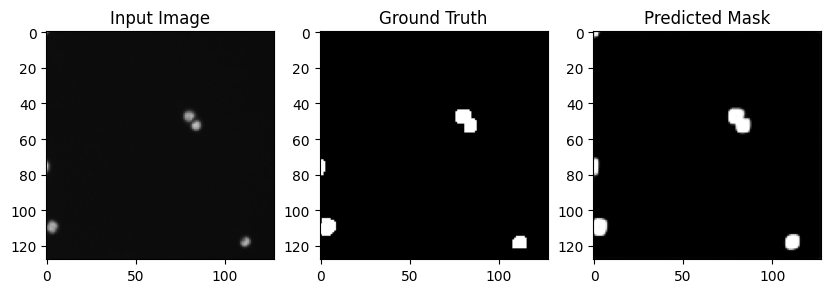

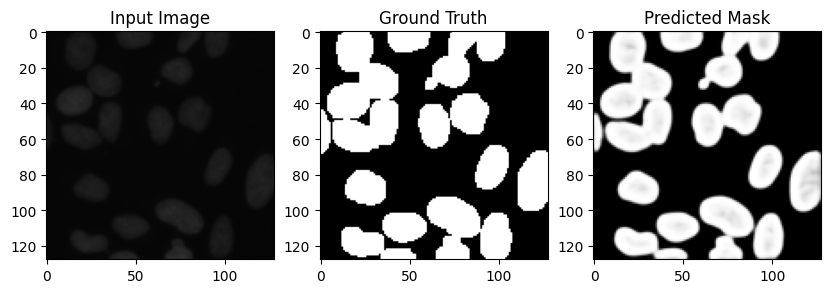

In [6]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        outputs = model(images)
        break  # Take one batch for visualization

# Visualize results
for i in range(4):  # Display first 4 samples in batch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
    plt.show()
